## 로지스틱 회귀

### 01 패키지 불러오기, 환경세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = '/content/drive/MyDrive/AI_serivce_track/Week_01'

In [ ]:
import torch # torch 라이브러리
import torch.nn  as  nn # torch 라이브러리 nn(neural net) 모듈을 nn으로 불러온다

import numpy as np
import pandas as pd

from sklearn import linear_model, model_selection
from sklearn.datasets import load_wine # sklearn에 내장된 datasets 중에 wine 데이터 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# torch.cuda 가 잡히면 "cuda"(GPU 가속)
# GPU 가속이 아닐 경우는 CPU로
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# os.path.join 이용해서 경로 지정
binomial_classification_data_path = os.path.join(base_path, 'diabetes.csv') # 데이터 불러오기

binomial_classification_feature_names = [
    "pregnant",  # 임신 횟수
    "glucose",  # 혈당 수치
    "bp",  # 혈압
    "skin",  # 피부 두께
    "insulin",  # 인슐린 수치
    "bmi",  # 체질량 지수
    "pedigree",  # 당뇨병 가족력
    "age",  # 나이
    "label",  # 당뇨병 여부 (0: 없음, 1: 있음)
]

# wine 데이터 불러오기
multinomial_classification_data_info = load_wine()
multinomial_classification_feature_names = (
    multinomial_classification_data_info.feature_names
)

test_data_ratio = 0.3
random_state = 0

num_binomial_class = 2
num_multinomial_class = 3

learning_rate = 5e-3 # 학습률 지정
epochs = 100 # 학습횟수 지정

criterion = nn.CrossEntropyLoss() # criterion 설정 CrossEntropyLoss

### 02 함수 정의

#### 02-01 Binomial 데이터 불러오는 함수 정의
- 수업 시간에 class, 모듈화된 코드를 받았는데, 이런 식으로 코드 짜는게 습관이 안되었음.
- BinomialClassificationDataLoader 클래스 정의
- MultinomialClassificationDataLoader 클래스 정의

In [ ]:
class BinomialClassificationDataLoader:
  # self는 원래 들어가고, path, feature_names, test_data_ratio, random_state인자로 받음
  def __init__(self, path, feature_names, test_data_ratio, random_state):
    # self.으로 class 내의 method? 정의?
    self.data_path = path
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    # csv_infos 라는 method 정의
    self.csv_infos = self.get_csv_infos()
    self.csv_data, self.csv_label = self.get_csv_dataset()
    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
      return self.train_data, self.train_label
    elif flag == 'test':
      return self.test_data, self.test_label

  def get_csv_infos(self):
    df = pd.read_csv(self.data_path, header=None).drop([0], axis=0)
    df.columns = self.feature_names

    return df

  def get_csv_dataset(self):
    data, label = self.csv_infos[self.feature_names[:-1]], self.csv_infos[self.feature_names[-1]].astype(int)

    return data.to_numpy().astype(np.float32), label.to_numpy().astype(np.float32)

  # 데이터 분할하기 sklearn.model_selection에서 train_test_split 사용
  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.csv_data, self.csv_label, test_size = self.test_data_ratio, random_state = self.random_state
    )

    return train_data, train_label, test_data, test_label

  # min-max normalize
  # 최소-최대값 이용한 정규화
  def min_max_normalize_data(self):
    min_values = np.min(self.train_data, axis=0)
    max_values = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min_values) / (max_values - min_values)
    self.test_data = (self.test_data - min_values) / (max_values - min_values)


#### 02-02 Multinomial 불러오는 class 정의

In [ ]:
class MultinomialClassificationDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
      return self.train_data, self.train_label
    elif flag == 'test':
      return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data.to_numpy().astype(np.float32), label.to_numpy().astype(np.float32)

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label

  def min_max_normalize_data(self):
    min_values = np.min(self.train_data, axis=0)
    max_values = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min_values) / (max_values - min_values)
    self.test_data = (self.test_data - min_values) / (max_values - min_values)

In [ ]:
binomial_classification_dataloader = BinomialClassificationDataLoader(binomial_classification_data_path, binomial_classification_feature_names, test_data_ratio, random_state)
binomial_classification_train_data, binomial_classification_train_label = binomial_classification_dataloader('train')
binomial_classification_test_data, binomial_classification_test_label = binomial_classification_dataloader('test')

multinomial_classifcation_dataloader = MultinomialClassificationDataLoader(multinomial_classification_data_info, multinomial_classification_feature_names, test_data_ratio, random_state)
multinomial_classifcation_train_data, multinomial_classifcation_train_label = multinomial_classifcation_dataloader('train')
multinomial_classifcation_test_data, multinomial_classifcation_test_label = multinomial_classifcation_dataloader('test')

print('binomial classification train data: {}/binomial classification train label: {}'.format(binomial_classification_train_data.shape, binomial_classification_train_label.shape))
print('binomial classification test data: {}/binomial classification test label: {}'.format(binomial_classification_test_data.shape, binomial_classification_test_label.shape))

print('multionomial classification train data: {}/multionomial classification train label: {}'.format(multinomial_classifcation_train_data.shape, multinomial_classifcation_train_label.shape))
print('multionomial classification test data: {}/multionomial classification test label: {}'.format(multinomial_classifcation_test_data.shape, multinomial_classifcation_test_label.shape))

binomial classification train data: (537, 8)/binomial classification train label: (537,)
binomial classification test data: (231, 8)/binomial classification test label: (231,)
multionomial classification train data: (124, 13)/multionomial classification train label: (124,)
multionomial classification test data: (54, 13)/multionomial classification test label: (54,)


#### 02-03 회귀모형 정의
- scikit-learn, torch 버전으로 정의

In [ ]:
class TorchBinomialLogisticRegression(nn.Module):
  def __init__(self, data, num_class):
    super(TorchBinomialLogisticRegression, self).__init__()
    self.logistic_regressor = nn.Linear(data.shape[1], num_class)

  def forward(self, data):
    logit = self.logistic_regressor(data)

    return logit

  def get_params(self):
    torch_weight, torch_bias = self.logistic_regressor.weight.detach().cpu().numpy(), self.logistic_regressor.bias.detach().cpu().numpy()

    return torch_weight, torch_bias

class TorchMultinomialLogisticRegression(nn.Module):
  def __init__(self, data, num_class):
    super(TorchMultinomialLogisticRegression, self).__init__()
    self.logistic_regressor = nn.Linear(data.shape[1], num_class)

  def forward(self, data):
    logit = self.logistic_regressor(data)

    return logit

  def get_params(self):
    torch_weight, torch_bias = self.logistic_regressor.weight.detach().cpu().numpy(), self.logistic_regressor.bias.detach().cpu().numpy()

    return torch_weight, torch_bias

class ScikitLearnLogisticRegression:
  def __init__(self):
    self.logistic_regressor = linear_model.LogisticRegression(penalty=None)

  def __call__(self, data):
    pred = self.logistic_regressor.predict(data)

    return pred

  def get_params(self):
    sklearn_weight, sklearn_bias = self.logistic_regressor.coef_, self.logistic_regressor.intercept_

    return sklearn_weight, sklearn_bias

binomial_sklearn_classifier = ScikitLearnLogisticRegression()
binomial_torch_classifier = TorchBinomialLogisticRegression(binomial_classification_train_data, num_binomial_class).to(device)
binomial_torch_model_optimizer = torch.optim.SGD(binomial_torch_classifier.parameters(), lr =learning_rate)

multinomial_sklearn_classifier = ScikitLearnLogisticRegression()
multinomial_torch_classifier = TorchMultinomialLogisticRegression(multinomial_classifcation_train_data, num_multinomial_class).to(device)
multinomial_torch_model_optimizer = torch.optim.SGD(multinomial_torch_classifier.parameters(), lr =learning_rate)

### 03. 모델 학습하기

In [ ]:
def train_sklearn_model(data, label, model):
  model.logistic_regressor.fit(data, label)


def train_torch_model(data, label, model, criterion, optimizer, epochs, device):
  model.train()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(
    label, dtype=torch.long
  ).to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()
    result = model(data)
    loss = criterion(result, label)
    loss.backward()
    optimizer.step()

train_sklearn_model(binomial_classification_train_data, binomial_classification_train_label, binomial_sklearn_classifier)
train_torch_model(binomial_classification_train_data, binomial_classification_train_label, binomial_torch_classifier, criterion, binomial_torch_model_optimizer, epochs, device)

train_sklearn_model(multinomial_classifcation_train_data, multinomial_classifcation_train_label, multinomial_sklearn_classifier)
train_torch_model(multinomial_classifcation_train_data, multinomial_classifcation_train_label, multinomial_torch_classifier, criterion, multinomial_torch_model_optimizer, epochs, device)

##### 파라미터 확인

In [ ]:
def show_parameters(sklearn_model, torch_model):
    sklearn_weight, sklearn_bias = sklearn_model.get_params()
    torch_weight, torch_bias = torch_model.get_params()

    print('sklearn weight: {}\ntorch weight: {}'.format(sklearn_weight, torch_weight))
    print('sklearn bias: {}\ntorch bias: {}'.format(sklearn_bias, torch_bias))


show_parameters(binomial_sklearn_classifier, binomial_torch_classifier)
show_parameters(multinomial_sklearn_classifier, multinomial_torch_classifier)

sklearn weight: [[ 1.47748911  6.75837874 -1.43522771  0.60710539 -1.08972668  6.03152711
   1.79393214  1.4903593 ]]
torch weight: [[ 0.24461839 -0.07010375  0.10770005  0.12351587  0.3536715   0.00222284
   0.10350859  0.04777805]
 [-0.09173697  0.04815549 -0.31144506  0.23720945 -0.1351945   0.03698039
   0.20778571  0.24696763]]
sklearn bias: [-8.00524747]
torch bias: [-0.07113787 -0.07699356]
sklearn weight: [[  9.56671288   2.53389535  11.92645035 -16.48150821  -2.8548377
    4.40664828  17.27892712  -4.31589773   1.4876653    0.73367026
   -3.80343657  12.12632472  18.4478884 ]
 [-13.1070208   -7.53774157 -19.65064088  10.21970658  -3.52440837
    1.21039798   5.49132624   3.12051388   7.47287609 -18.50861259
   16.81254361   7.4601098  -17.54013994]
 [  3.54030792   5.00384623   7.72419052   6.26180162   6.37924607
   -5.61704626 -22.77025336   1.19538384  -8.96054139  17.77494233
  -13.00910704 -19.58643452  -0.90774846]]
torch weight: [[ 0.31276584 -0.08693668 -0.15599312  0.

### 04 모델 테스트하기

In [ ]:
def test_model(data, label, model, flag):
  result = model(data)

  accuracy = accuracy_score(label, result)
  print('acc: {}'.format(accuracy))

  if flag == 'binomial':
    recall = recall_score(label, result)
    precision = precision_score(label, result)
    f1_measure = f1_score(label, result)

    print('recall: {}'.format(recall))
    print('precision: {}'.format(precision))
    print('f1 score: {}'.format(f1_measure))

def test_torch_model(data, label, model, device, flag):
  model.eval()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).detach().cpu().numpy()

  with torch.no_grad():
    result = model(data)
    _, result = torch.max(result, 1)

    if device.type == "cuda":
      result = result.cpu().numpy()

    accuracy = accuracy_score(label, result)
    print('acc: {}'.format(accuracy))

    if flag == 'binomial':
      recall = recall_score(label, result)
      precision = precision_score(label, result)
      f1_measure = f1_score(label, result)

      print('recall: {}'.format(recall))
      print('precision: {}'.format(precision))
      print('f1 score: {}'.format(f1_measure))


print('Scikit-Learn Binomail Logstic Regression / Torch Binomial Logstic Regression')
test_model(binomial_classification_test_data, binomial_classification_test_label, binomial_sklearn_classifier, 'binomial')
test_torch_model(binomial_classification_test_data, binomial_classification_test_label, binomial_torch_classifier, device, 'binomial')

print('Scikit-Learn Multinomial Logstic Regression / Torch Multinomial Logstic Regression')
test_model(multinomial_classifcation_test_data, multinomial_classifcation_test_label, multinomial_sklearn_classifier, 'multinomial')
test_torch_model(multinomial_classifcation_test_data, multinomial_classifcation_test_label, multinomial_torch_classifier, device, 'multinomial')

Scikit-Learn Binomail Logstic Regression / Torch Binomial Logstic Regression
acc: 0.7792207792207793
recall: 0.527027027027027
precision: 0.7090909090909091
f1 score: 0.6046511627906976
acc: 0.6883116883116883
recall: 0.06756756756756757
precision: 0.625
f1 score: 0.12195121951219512
Scikit-Learn Multinomial Logstic Regression / Torch Multinomial Logstic Regression
acc: 1.0
acc: 0.4074074074074074


#### (참고) likelihood-study

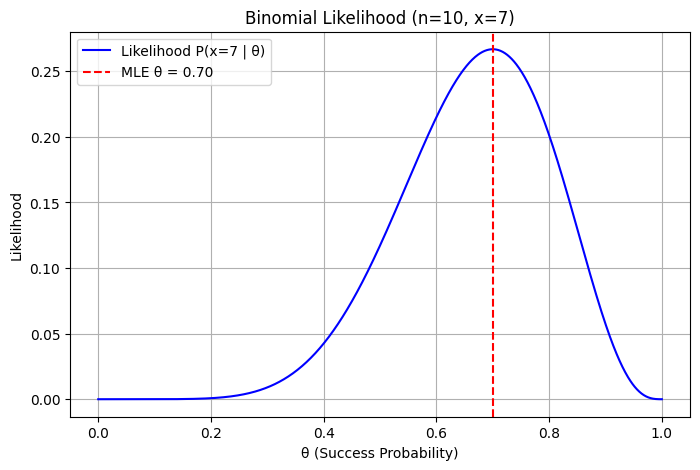

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# 관측값: 성공 횟수 x, 시행 횟수 n
n = 10   # 시행 횟수
x = 7    # 성공 횟수 (관측값)

# θ(성공 확률)의 범위 정의
theta_vals = np.linspace(0, 1, 1000)

# Binomial likelihood 계산
likelihood_vals = binom.pmf(x, n, theta_vals)

# 최대 Likelihood 지점
mle_theta = theta_vals[np.argmax(likelihood_vals)]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(theta_vals, likelihood_vals, label=f'Likelihood P(x={x} | θ)', color='blue')
plt.axvline(mle_theta, color='red', linestyle='--', label=f'MLE θ = {mle_theta:.2f}')
plt.title(f'Binomial Likelihood (n={n}, x={x})')
plt.xlabel('θ (Success Probability)')
plt.ylabel('Likelihood')
plt.legend()
plt.grid(True)
plt.show()